# Predicting Uber Fare Prices
## Mark Bowen & John Ruscito & Peyton Theil

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as lm
from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import pipeline
from sklearn.metrics import mean_squared_error

### Import data and Inspect the Data

In [2]:
uber_data = pd.read_csv("uber.csv")
print("Shape of the Data: ", uber_data.shape)
uber_data.head()

Shape of the Data:  (200000, 9)


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [3]:
print(uber_data.isnull().sum())
uber_data = uber_data.dropna()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


## Data

### Feature Engineer pickup_datetime

In [4]:
uber_data.pickup_datetime = pd.to_datetime(uber_data.pickup_datetime, format = '%Y-%m-%d %H:%M:%S UTC', errors='coerce')

In [5]:
uber_data.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5


In [6]:
(uber_data.pickup_datetime == "NaT").sum()

0

Extract extra information from pickup_datetime. <br>
Year is not important since it will never repeat (i.e. it will never be 2019 again)

In [7]:
uber_data['pickup_month'] = uber_data.pickup_datetime.dt.month
uber_data['pickup_week'] = uber_data.pickup_datetime.dt.isocalendar().week
uber_data['pickup_day'] = uber_data.pickup_datetime.dt.day
uber_data['pickup_hour'] = uber_data.pickup_datetime.dt.hour
uber_data['pickup_minute'] = uber_data.pickup_datetime.dt.minute
uber_data['pickup_dayofweek'] = uber_data.pickup_datetime.dt.dayofweek
uber_data[['pickup_month', 'pickup_week', 'pickup_day', 'pickup_hour', 'pickup_minute', 'pickup_dayofweek']].head()

,pickup_month,pickup_week,pickup_day,pickup_hour,pickup_minute,pickup_dayofweek
0,5,19,7,19,52,3
1,7,29,17,20,4,4
2,8,35,24,21,45,0
3,6,26,26,8,22,4
4,8,35,28,17,47,3


Now that we have extracted the useful information out of pickup_datetime, we can remove the column from the data

In [8]:
uber_data = uber_data.drop(columns = ['pickup_datetime', 'key', 'Unnamed: 0'])
uber_data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_month,pickup_week,pickup_day,pickup_hour,pickup_minute,pickup_dayofweek
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,5,19,7,19,52,3
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,7,29,17,20,4,4
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,8,35,24,21,45,0
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,6,26,26,8,22,4
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,8,35,28,17,47,3


Let's also drop key and id since they are not necessary for learning

In [9]:
from seaborn import pairplot

In [10]:
# pairplot(uber_data.head(25))

### Create X (all features) and Y (fare_amount)

In [11]:
Y = uber_data.fare_amount
X = uber_data.drop(columns='fare_amount')
print("X shape: {} \nY shape: {}".format(X.shape, Y.shape))

X shape: (199999, 11) 
Y shape: (199999,)


### Split Data into Training sets and Testing sets

In [12]:
Xtr, Xte, Ytr, Yte = ms.train_test_split(X, Y) # shuffle is true by default & test_size is .25 by default
print("Xtr shape: {} \nXte shape: {} \nYtr shape: {}\nYte shape: {}".format(Xtr.shape, Xte.shape, Ytr.shape, Yte.shape))

Xtr shape: (149999, 11) 
Xte shape: (50000, 11) 
Ytr shape: (149999,)
Yte shape: (50000,)


## Search for the best preprocessing techniques

# This is going to be computationally *expensive*!!!

In [13]:
base_model = lm.Ridge(alpha = .01)

In [14]:
model_grid = {
    "Ridge Alpha = .1: ": lm.Ridge(alpha = .1), 
    "Ridge Alpha = .01: ": lm.Ridge(alpha = .01), 
    "Ridge Alpha = .001: ": lm.Ridge(alpha = .001), 
    "Ridge Alpha = .0001: ": lm.Ridge(alpha = .0001)
    }
scaler_grid = {
    'MinMax': pp.MinMaxScaler(), 
    'Robust': pp.RobustScaler(), 
    'Standard': pp.StandardScaler()
    }
transformer_grid = {
    'Quantile': pp.QuantileTransformer()
#, 'Power': pp.PowerTransformer()
    }

In [15]:
scores = {}
base_model.fit(Xtr, Ytr)
base_y_preds = base_model.predict(Xte)
error = mean_squared_error(base_y_preds, Yte)
print("No Transformations: {}".format(error))
scores["No Transformations"] = error
best_score = error
best_model_name = "base_model"
best_model = None
best_scaler_name = "None"
best_scaler = None
best_transformer_name = "None"
best_transformer = None

for h, (model_name, model) in enumerate(model_grid.items()):
    for i, (scaler_name, scaler) in enumerate(scaler_grid.items()):
        for j, (transformer_name, transformer) in enumerate(transformer_grid.items()):
            pipe = pipeline.make_pipeline(scaler, transformer, model)
            pipe.fit(Xtr, Ytr)
            y_preds = pipe.predict(Xte)
            score = mean_squared_error(y_preds, Yte)
            combination = scaler_name + ", " + transformer_name
            scores[combination] = score
            print("{} {}".format(combination, score))
            if score < best_score:
                best_score = score
                best_model_name = model_name
                best_model = model
                best_scaler_name = scaler_name
                best_scaler = scaler
                best_transformer_name = transformer_name
                best_transformer = transformer
                best_pipe = pipe

print("\nBest Combination:\nBest Scaler: {}\nBest Transformer: {}\nBest Score: {}".format(best_scaler_name, best_transformer_name, best_score))


No Transformations: 96.1243290571543
MinMax, Quantile 89.56748048922802
Robust, Quantile 89.56669855356002
Standard, Quantile 89.57109645040657
MinMax, Quantile 89.57612606402294
Robust, Quantile 89.5540452965876
Standard, Quantile 89.57546825044963
MinMax, Quantile 89.56547392460647
Robust, Quantile 89.57111219471614
Standard, Quantile 89.57122386655553
MinMax, Quantile 89.57609078852573
Robust, Quantile 89.56988938844309
Standard, Quantile 89.5654292197321

Best Combination:
Best Scaler: Robust
Best Transformer: Quantile
Best Score: 89.5540452965876


Lets see if polynomial features plays any part now...

In [16]:
cv_scores = ms.cross_validate(best_pipe, Xtr, Ytr, scoring = "neg_root_mean_squared_error")

In [17]:
cv_scores['test_score']

array([-9.97307149, -9.60702843, -9.4502023 , -9.5819947 , -9.25993682])

In [18]:
poly_feats_grid = {
    "pf = 1: ": pp.PolynomialFeatures(degree = 1), 
    "pf = 2:": pp.PolynomialFeatures(degree = 2),
    "pf = 3: ": pp.PolynomialFeatures(degree = 3),
    "pf = 4:": pp.PolynomialFeatures(degree = 4),
    }

In [19]:
scores = {}
base_model.fit(Xtr, Ytr)
base_y_preds = base_model.predict(Xte)
error = mean_squared_error(base_y_preds, Yte)
print("No Transformations: {}".format(error))
scores["No Transformations"] = error
best_score = error
best_model_name = "base_model"
best_model = None
best_scaler_name = "None"
best_scaler = None
best_transformer_name = "None"
best_transformer = None

for h, (model_name, model) in enumerate(model_grid.items()):
    for i, (scaler_name, scaler) in enumerate(scaler_grid.items()):
        for j, (transformer_name, transformer) in enumerate(transformer_grid.items()):
            for k, (pf_degree, poly_feats) in enumerate(poly_feats_grid.items()):
                pipe = pipeline.make_pipeline(scaler, transformer, poly_feats, model)
                #pipe.fit(Xtr, Xte)
                cv_scores = ms.cross_validate(pipe.fit(Xtr, Ytr), Xtr, Ytr, scoring='neg_mean_squared_error')
                #y_preds = pipe.predict(Xte)
                combination = model_name + ", " + scaler_name + ", " + transformer_name + ", " + pf_degree + ": "
                # score = mean_squared_error(y_preds, Yte)
                score = -1 * (sum(cv_scores['test_score']) / len(cv_scores['test_score']))
                scores[combination] = score
                print("{}: {}\n".format(combination, scores[combination]))
                if score < best_score:
                    best_score = score
                    best_model_name = model_name
                    best_model = model
                    best_scaler_name = scaler_name
                    best_scaler = scaler
                    best_transformer_name = transformer_name
                    best_transformer = transformer
                    best_pf_degree = pf_degree
                    best_pf = poly_feats
                    #best_y_preds = y_preds
                    best_pipe = pipe
                    best_cv_stats = cv_scores
                    print("\nNew Best: {}, {}, {}, {}\nScore: {}".format(model_name, scaler_name, transformer_name, pf_degree, score))

print("\nBest Combination:\nBest Alpha: {}\nBest Scaler: {}\nBest Transformer: {}\nBest PolyFeat Degree: {}\nBest Score: {}".format(best_model_name, best_scaler_name, best_transformer_name, best_pf_degree, best_score))


No Transformations: 96.1243290571543
Ridge Alpha = .1: , MinMax, Quantile, pf = 1: : : 91.72457497986784


New Best: Ridge Alpha = .1: , MinMax, Quantile, pf = 1: 
Score: 91.72457497986784
Ridge Alpha = .1: , MinMax, Quantile, pf = 2:: : 53.6648879341246


New Best: Ridge Alpha = .1: , MinMax, Quantile, pf = 2:
Score: 53.6648879341246
Ridge Alpha = .1: , MinMax, Quantile, pf = 3: : : 48.83879323434083


New Best: Ridge Alpha = .1: , MinMax, Quantile, pf = 3: 
Score: 48.83879323434083
Ridge Alpha = .1: , MinMax, Quantile, pf = 4:: : 40.914670704131495


New Best: Ridge Alpha = .1: , MinMax, Quantile, pf = 4:
Score: 40.914670704131495
Ridge Alpha = .1: , Robust, Quantile, pf = 1: : : 91.72539557209132

Ridge Alpha = .1: , Robust, Quantile, pf = 2:: : 53.66778956575308

Ridge Alpha = .1: , Robust, Quantile, pf = 3: : : 48.82276410912975

Ridge Alpha = .1: , Robust, Quantile, pf = 4:: : 40.90420992924642


New Best: Ridge Alpha = .1: , Robust, Quantile, pf = 4:
Score: 40.90420992924642
Rid

In [20]:
best_pipe.named_steps

{'minmaxscaler': MinMaxScaler(),
 'quantiletransformer': QuantileTransformer(),
 'polynomialfeatures': PolynomialFeatures(degree=4),
 'ridge': Ridge(alpha=0.01)}

## Time to put our best model up against the Test Set

In [21]:
best_pipe.fit(Xtr, Ytr)
y_preds = best_pipe.predict(Xte)
rmse = mean_squared_error(Yte, y_preds)
print("Test Error: {}".format(rmse))

Test Error: 39.43541870508398


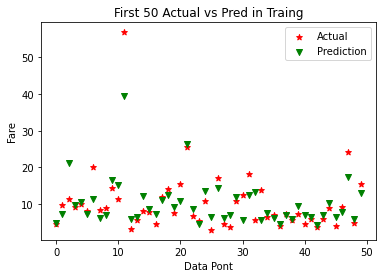

In [24]:
plt.title("First 50 Actual vs Pred in Traing")
plt.ylabel("Fare")
plt.xlabel("Data Pont")
plt.scatter(np.arange(0, 50), Yte[:50], color='r', label = "Actual", marker = '*')
plt.scatter(np.arange(0, 50), y_preds[:50], color = 'g', label = "Prediction", marker = 'v')
plt.legend()